# Model Evaluation and Improvement

In this chapter two new concepts are introduced:
* Cross-validation 
* Grid search

##### Index:
* Cross-Validation
    * Stratified Cross-Validation
    * Leave-One-Out Cross-Validation
    * Shuffle-Split Cross-Validation
    * Cross-Validation with groups
* Grid Search
    * Simple Grid Search
    * The Danger of Overfitting the Parameters and the Validation Set
    * Grid Search with Cross-Validation
* Evaluation Metrics and Scoring
    * Metrics for Binary Classification
    * Metrics for Multiclass Classification
    * Regression Metrics
    * Using Evaluation Metrics in Model Selection

In [1]:
import pandas as pd
import numpy as np
import mglearn
import IPython.display
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore")

%matplotlib inline

# Cross-Validation

A way to test generalization that is more robust than just splitting into training and test sets.

In Cross-Validation the data is splitted and trained repeatedly. 


The most famous one is the k-fold validation. The data is splitted into a set number of folds and then the first fold is used for testing and the rest for training, then the second and so on. 

In the end we have several accuracy values.

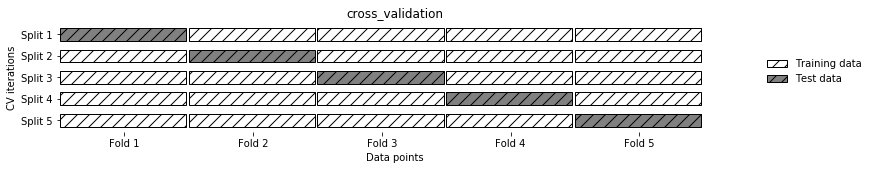

In [2]:
mglearn.plots.plot_cross_validation()

We apply cross validation with cross_val_score

In [3]:
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression

iris = load_iris()
logreg = LogisticRegression()

scores = cross_val_score(logreg, iris['data'], iris['target'])
print("Cross-validation scores: {}".format(scores))

Cross-validation scores: [0.96078431 0.92156863 0.95833333]


It returned the score of three folds as a default, but we can change that with cv parameter.

In [4]:
scores = cross_val_score(logreg, iris['data'], iris['target'], cv = 5)
print("Cross-validation scores: {}".format(scores))

Cross-validation scores: [1.         0.96666667 0.93333333 0.9        1.        ]


Computing the mean is an easy way to summarize the results for cross-validation

In [5]:
print("Average cross-validation score: {:.2f}".format(scores.mean()))

Average cross-validation score: 0.96


Another option for doing cross-validation is the cross_validate method

In [6]:
from sklearn.model_selection import cross_validate
res = cross_validate(logreg, iris.data, iris.target, cv=5,
                     return_train_score=True)
display(res)

{'fit_time': array([0.        , 0.        , 0.        , 0.00398684, 0.        ]),
 'score_time': array([0., 0., 0., 0., 0.]),
 'test_score': array([1.        , 0.96666667, 0.93333333, 0.9       , 1.        ]),
 'train_score': array([0.95      , 0.96666667, 0.96666667, 0.975     , 0.95833333])}

In [7]:
# With pandas we can display everything nicely
res_df = pd.DataFrame(res)
display(res_df)
print("Mean times and scores:\n", res_df.mean())

,fit_time,score_time,test_score,train_score
0,0.000000,0.0,1.000000,0.950000
1,0.000000,0.0,0.966667,0.966667
2,0.000000,0.0,0.933333,0.966667
3,0.003987,0.0,0.900000,0.975000
4,0.000000,0.0,1.000000,0.958333


Mean times and scores:
 fit_time       0.000797
score_time     0.000000
test_score     0.960000
train_score    0.963333
dtype: float64


##### Benefits of Cross- Validation

If we only do a train_test_split we might get good or bad luck by having certain elements in the train set. With cross-validation this is solved.

The purpose of cross-validation is not to build a model, but to evaluate how well a given algorithm will generalize when trained on a specific dataset.

## Stratified cross-validation

While doing classification it is better to use stratified cross-validation in order to avoid stuff like having only one class in a single fold.

If 90% of the data belongs to A and 10% to B, then the resulting folds will have 90% A and 10%B as well.

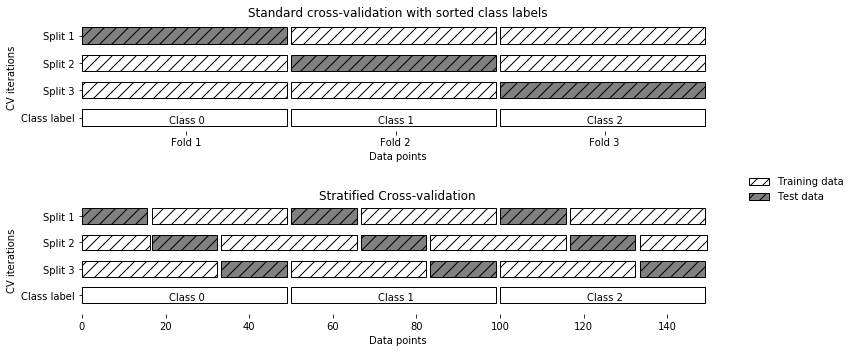

In [8]:
mglearn.plots.plot_stratified_cross_validation()

We can get more control on the cross-validation with KFold class

In [9]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5)

In [10]:
print("Cross-validation scores:\n{}".format(
      cross_val_score(logreg, iris.data, iris.target, cv=kfold)))

Cross-validation scores:
[1.         0.93333333 0.43333333 0.96666667 0.43333333]


In [11]:
kfold = KFold(n_splits=3)
print("Cross-validation scores:\n{}".format(
    cross_val_score(logreg, iris.data, iris.target, cv=kfold)))

Cross-validation scores:
[0. 0. 0.]


Insted of stratifying we could shuffle the dataset so there are no folds with only a single class by using KFold class.

In [12]:
kfold = KFold(n_splits=3, shuffle=True, random_state=0)
print("Cross-validation scores:\n{}".format(
    cross_val_score(logreg, iris.data, iris.target, cv=kfold)))

Cross-validation scores:
[0.9  0.96 0.96]


## Leave-One-Out Cross-Validation

You split the data into folds and use a single datapoint for testing the model.

It can provide good estimates on small datasets

In [13]:
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()
scores = cross_val_score(logreg, iris.data, iris.target, cv=loo)
print("Number of cv iterations: ", len(scores))
print("Mean accuracy: {:.2f}".format(scores.mean()))

Number of cv iterations:  150
Mean accuracy: 0.95


## Shuffle-Split Cross-Validation

It splits the data into a specified number of folds, then it trains train_size many points and tests on test_size many points and the splitting is repeated n_split times.

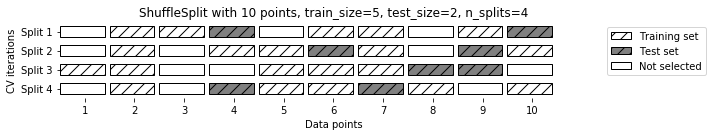

In [14]:
mglearn.plots.plot_shuffle_split()

In [15]:
from sklearn.model_selection import ShuffleSplit
shuffle_split = ShuffleSplit(test_size=.5, train_size=.5, n_splits=10)
scores = cross_val_score(logreg, iris.data, iris.target, cv=shuffle_split)
print("Cross-validation scores:\n{}".format(scores))

Cross-validation scores:
[0.96       0.93333333 0.97333333 0.97333333 0.92       0.96
 0.88       0.90666667 0.93333333 0.89333333]


#### Note:
There is a classification variant called StratifiedShuffleSplit

## Cross-Validation with groups

If you have points of related data, like datapoints corresponding to the same patient in a medical situation, one might like to prevent all the training set belonging to the same person.

That is where this comes in handy. By tagging the groups as in the example below, the algorithm will perform cross-validation.

In the example, each gorup is either entirely on the test set or entirely on the training set. But there is not a single group on the training set.

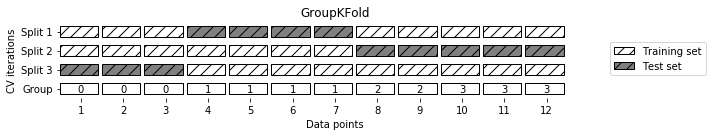

In [16]:
mglearn.plots.plot_group_kfold()

In [17]:
from sklearn.model_selection import GroupKFold
from sklearn.datasets import make_blobs
# create synthetic dataset
X, y = make_blobs(n_samples=12, random_state=0)
# assume the first three samples belong to the same group,
# then the next four, etc.
groups = [0, 0, 0, 1, 1, 1, 1, 2, 2, 3, 3, 3]
scores = cross_val_score(logreg, X, y, groups, cv=GroupKFold(n_splits=3))
print("Cross-validation scores:\n{}".format(scores))

Cross-validation scores:
[0.75       0.8        0.66666667]


### Note
There are more cross-validation techniques in scikit-learn but the ones shown above are the most common ones

# Grid Search

Grid Search is a method to search for the best parameters, which consists on trying all the possible combinations of of the parameters of interest.

## Simple Grid Search

We can implement a Grid Search by simple running for loops and training a model for each iteration

In [18]:
# naive grid search implementation
from sklearn.svm import SVC
X_train, X_test, y_train, y_test = train_test_split(
    iris.data, iris.target, random_state=0)
print("Size of training set: {}   size of test set: {}".format(
      X_train.shape[0], X_test.shape[0]))

best_score = 0

for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        # for each combination of parameters, train an SVC
        svm = SVC(gamma=gamma, C=C)
        svm.fit(X_train, y_train)
        # evaluate the SVC on the test set
        score = svm.score(X_test, y_test)
        # if we got a better score, store the score and parameters
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}

print("Best score: {:.2f}".format(best_score))
print("Best parameters: {}".format(best_parameters))

Size of training set: 112   size of test set: 38
Best score: 0.97
Best parameters: {'C': 100, 'gamma': 0.001}


This time we selected the best parameters based on their performance on the test set, but this might be dangerous because the purpose of separating training and test is to have test be totally new data to the model.

To solve this we create another separation: The validation set. After finding the best parameters using the validation set, we can now train a new model by using both, the train and the validation data

#### NOTE:
ONLY USE TEST SETS FOR THE FINAL EVALUATION

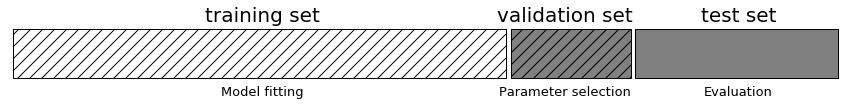

In [19]:
mglearn.plots.plot_threefold_split()

In [20]:
from sklearn.svm import SVC
# split data into train+validation set and test set
X_trainval, X_test, y_trainval, y_test = train_test_split(
    iris.data, iris.target, random_state=0)
# split train+validation set into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(
    X_trainval, y_trainval, random_state=1)
print("Size of training set: {}   size of validation set: {}   size of test set:"
      " {}\n".format(X_train.shape[0], X_valid.shape[0], X_test.shape[0]))

best_score = 0

for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        # for each combination of parameters, train an SVC
        svm = SVC(gamma=gamma, C=C)
        svm.fit(X_train, y_train)
        # evaluate the SVC on the validation set
        score = svm.score(X_valid, y_valid)
        # if we got a better score, store the score and parameters
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}

# rebuild a model on the combined training and validation set,
# and evaluate it on the test set
svm = SVC(**best_parameters)
svm.fit(X_trainval, y_trainval)
test_score = svm.score(X_test, y_test)
print("Best score on validation set: {:.2f}".format(best_score))
print("Best parameters: ", best_parameters)
print("Test set score with best parameters: {:.2f}".format(test_score))

Size of training set: 84   size of validation set: 28   size of test set: 38

Best score on validation set: 0.96
Best parameters:  {'C': 10, 'gamma': 0.001}
Test set score with best parameters: 0.92


## Grid Search with Cross-Validation

For a better estimation of generalization performance, instead of just splitting into train, validation and test, we could use cross-validation.

This basically means that we take the best mean score after the cross-validation with each combination of parameters.

The method can be coded up as follows:

In [21]:
for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        # for each combination of parameters,
        # train an SVC
        svm = SVC(gamma=gamma, C=C)
        # perform cross-validation
        scores = cross_val_score(svm, X_trainval, y_trainval, cv=5)
        # compute mean cross-validation accuracy
        score = np.mean(scores)
        # if we got a better score, store the score and parameters
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}
# rebuild a model on the combined training and validation set
svm = SVC(**best_parameters)
svm.fit(X_trainval, y_trainval)

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

For each parameter combination, 5 accuracy values are computed and then the mean of them is calculated.

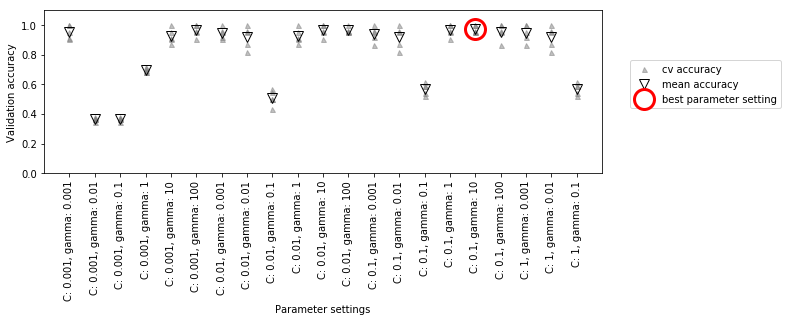

In [22]:
mglearn.plots.plot_cross_val_selection()

The overall process of splitting the data, running the grid search, and evaluating the final parameters:

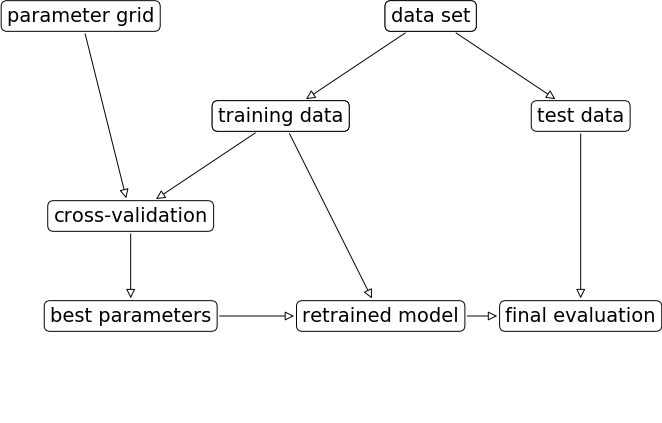

In [23]:
mglearn.plots.plot_grid_search_overview()

Scikit-learn has the calss GridSearchCV to perform grid search with cross-validation.

To use it we need to first build a dictionary with the desired parameters to test.

In [24]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
print("Parameter grid:\n{}".format(param_grid))

Parameter grid:
{'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}


In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
grid_search = GridSearchCV(SVC(), param_grid, cv=5,
                          return_train_score=True)




In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    iris.data, iris.target, random_state=0)


grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

The GridsSearchCV also trains the model with the best parameters found, so we can use it to score the model.

In [27]:
print("Test set score: {:.2f}".format(grid_search.score(X_test, y_test)))

Test set score: 0.97


The best parameters and the best cross-validation accuracy can be accessed as follows

In [28]:
print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

Best parameters: {'C': 100, 'gamma': 0.01}
Best cross-validation score: 0.97


We cann access the actual best model with the best_estimator_ attribute.

In [29]:
print("Best estimator:\n{}".format(grid_search.best_estimator_))

Best estimator:
SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


### Analyzing the result of cross-validation

We can visualize the results of a grid search with the cv_results_attribute and transforming it into a pandas DataFrame.

Each row corresponds to a particular parameter setting.

In [30]:
import pandas as pd
# convert to Dataframe
results = pd.DataFrame(grid_search.cv_results_)
# show the first 5 rows
display(results.head())

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.000792,0.001583,0.0,0.0,0.001,0.001,"{'C': 0.001, 'gamma': 0.001}",0.375,0.347826,0.363636,...,0.366071,0.011371,22,0.363636,0.370787,0.366667,0.366667,0.362637,0.366079,0.002852
1,0.000800,0.001601,0.0,0.0,0.001,0.01,"{'C': 0.001, 'gamma': 0.01}",0.375,0.347826,0.363636,...,0.366071,0.011371,22,0.363636,0.370787,0.366667,0.366667,0.362637,0.366079,0.002852
2,0.000000,0.000000,0.0,0.0,0.001,0.1,"{'C': 0.001, 'gamma': 0.1}",0.375,0.347826,0.363636,...,0.366071,0.011371,22,0.363636,0.370787,0.366667,0.366667,0.362637,0.366079,0.002852
3,0.002400,0.001960,0.0,0.0,0.001,1,"{'C': 0.001, 'gamma': 1}",0.375,0.347826,0.363636,...,0.366071,0.011371,22,0.363636,0.370787,0.366667,0.366667,0.362637,0.366079,0.002852
4,0.000000,0.000000,0.0,0.0,0.001,10,"{'C': 0.001, 'gamma': 10}",0.375,0.347826,0.363636,...,0.366071,0.011371,22,0.363636,0.370787,0.366667,0.366667,0.362637,0.366079,0.002852


We can also visualize the scores with a heatmap when there are only two parameters to tune.

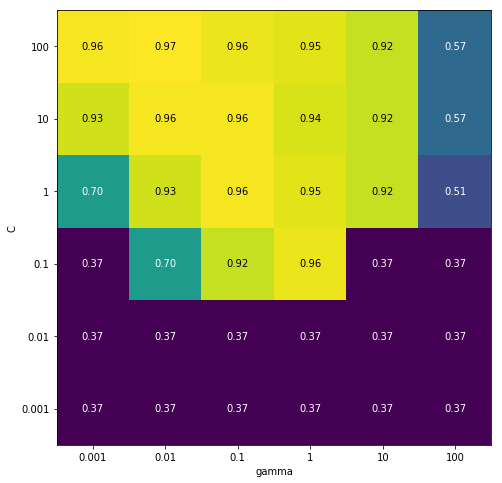

In [31]:
scores = np.array(results["mean_test_score"]).reshape(6, 6)

# plot the mean cross-validation scores
plt.figure(figsize = (14,8))
mglearn.tools.heatmap(scores, xlabel='gamma', xticklabels=param_grid['gamma'],
                      ylabel='C', yticklabels=param_grid['C'], cmap="viridis")
plt.show()

Now we can visualize a case in which the plot is not that ideal. The first panel shows no changes, caused by the improper scaling and range of the parameters.

In the second case, as there are only vertical groups, it seems like only gamma matters.

In the third one, as the optimum parameter is in the corner, we can expect more parameters to be beyond that.

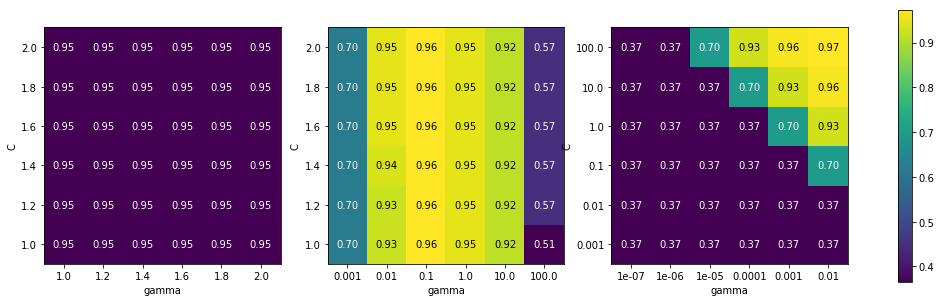

In [32]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

param_grid_linear = {'C': np.linspace(1, 2, 6),
                     'gamma':  np.linspace(1, 2, 6)}

param_grid_one_log = {'C': np.linspace(1, 2, 6),
                      'gamma':  np.logspace(-3, 2, 6)}

param_grid_range = {'C': np.logspace(-3, 2, 6),
                    'gamma':  np.logspace(-7, -2, 6)}

for param_grid, ax in zip([param_grid_linear, param_grid_one_log,
                           param_grid_range], axes):
    grid_search = GridSearchCV(SVC(), param_grid, cv=5)
    grid_search.fit(X_train, y_train)
    scores = grid_search.cv_results_['mean_test_score'].reshape(6, 6)

    # plot the mean cross-validation scores
    scores_image = mglearn.tools.heatmap(
        scores, xlabel='gamma', ylabel='C', xticklabels=param_grid['gamma'],
        yticklabels=param_grid['C'], cmap="viridis", ax=ax)

plt.colorbar(scores_image, ax=axes.tolist())
plt.show()

### Search over spaces that are not grids

It is possible to build a param_grid with a list of dictionaries instead of a single dictionary. This allows for more flexibility while testing the parameters on a Search Grid.

In [33]:
param_grid = [{'kernel': ['rbf'],
               'C': [0.001, 0.01, 0.1, 1, 10, 100],
               'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
              {'kernel': ['linear'],
               'C': [0.001, 0.01, 0.1, 1, 10, 100]}]
print("List of grids:\n{}".format(param_grid))

List of grids:
[{'kernel': ['rbf'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}, {'kernel': ['linear'], 'C': [0.001, 0.01, 0.1, 1, 10, 100]}]


In [34]:
grid_search = GridSearchCV(SVC(), param_grid, cv=5,
                          return_train_score=True)
grid_search.fit(X_train, y_train)
print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

Best parameters: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
Best cross-validation score: 0.97


In [35]:
results = pd.DataFrame(grid_search.cv_results_)
# We display the transpoes table so that it better fits on the page
display(results.T)

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
mean_fit_time,0.000799751,0,0.00160017,0.000806189,0,0.000807762,0.00159974,0.000799894,0,0.000800467,...,0,0,0.000800037,0.000801134,0.000800085,0,0,0.000799894,0,0.000800085
std_fit_time,0.0015995,0,0.0019598,0.00161238,0,0.00161552,0.00195933,0.00159979,0,0.00160093,...,0,0,0.00160007,0.00160227,0.00160017,0,0,0.00159979,0,0.00160017
mean_score_time,0,0,0,0.000798893,0.00159535,0,0,0,0,0,...,0,0.000799751,0.000799942,0.000798798,0,0,0.000800943,0,0,0
std_score_time,0,0,0,0.00159779,0.0019539,0,0,0,0,0,...,0,0.0015995,0.00159988,0.0015976,0,0,0.00160189,0,0,0
param_C,0.001,0.001,0.001,0.001,0.001,0.001,0.01,0.01,0.01,0.01,...,100,100,100,100,0.001,0.01,0.1,1,10,100
param_gamma,0.001,0.01,0.1,1,10,100,0.001,0.01,0.1,1,...,0.1,1,10,100,NaN,NaN,NaN,NaN,NaN,NaN
param_kernel,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,...,rbf,rbf,rbf,rbf,linear,linear,linear,linear,linear,linear
params,"{'C': 0.001, 'gamma': 0.001, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 0.01, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 1, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 10, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 100, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 0.001, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 1, 'kernel': 'rbf'}",...,"{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 100, 'gamma': 1, 'kernel': 'rbf'}","{'C': 100, 'gamma': 10, 'kernel': 'rbf'}","{'C': 100, 'gamma': 100, 'kernel': 'rbf'}","{'C': 0.001, 'kernel': 'linear'}","{'C': 0.01, 'kernel': 'linear'}","{'C': 0.1, 'kernel': 'linear'}","{'C': 1, 'kernel': 'linear'}","{'C': 10, 'kernel': 'linear'}","{'C': 100, 'kernel': 'linear'}"
split0_test_score,0.375,0.375,0.375,0.375,0.375,0.375,0.375,0.375,0.375,0.375,...,0.958333,0.916667,0.875,0.541667,0.375,0.916667,0.958333,1,0.958333,0.958333
split1_test_score,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,...,1,1,0.956522,0.521739,0.347826,0.826087,0.913043,0.956522,1,1


### Using different cross-validation strategies with Grid Search

You can pass a ShuffleSplit or a StratifiedShuffleSplit to the cv parameter in GridSearch to use different kind of splitters instead of the default ones. 

Using the mentioned classes with n-splits = 1 can help improve performance on large datasets or slow models, as it does the cross-validation with only one split in trianing and validation sets.

### Nested cross-validation

Instead of splitting the data into training and datasets once, we can use multiple splits of cross-validation.

For each of the splits a grid search is run. For implementing this, we can use cross_val_score with GridSearch as its model.

The result of this is a list of scores, not a model nor a parameter setting, therefore it is not that used in practice for building a prediction model, but it can be used to see how a model works on a particular dataset.

In [36]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
scores = cross_val_score(GridSearchCV(SVC(), param_grid, cv=5),
                         iris.data, iris.target, cv=5)
print("Cross-validation scores: ", scores)
print("Mean cross-validation score: ", scores.mean())

Cross-validation scores:  [0.96666667 1.         0.96666667 0.96666667 1.        ]
Mean cross-validation score:  0.9800000000000001


We can also look at what the previous code is doing with for loops:

In [37]:
def nested_cv(X, y, inner_cv, outer_cv, Classifier, parameter_grid):
    outer_scores = []
    # for each split of the data in the outer cross-validation
    # (split method returns indices of training and test parts)
    for training_samples, test_samples in outer_cv.split(X, y):
        # find best parameter using inner cross-validation
        best_parms = {}
        best_score = -np.inf
        # iterate over parameters
        for parameters in parameter_grid:
            # accumulate score over inner splits
            cv_scores = []
            # iterate over inner cross-validation
            for inner_train, inner_test in inner_cv.split(
                    X[training_samples], y[training_samples]):
                # build classifier given parameters and training data
                clf = Classifier(**parameters)
                clf.fit(X[inner_train], y[inner_train])
                # evaluate on inner test set
                score = clf.score(X[inner_test], y[inner_test])
                cv_scores.append(score)
            # compute mean score over inner folds
            mean_score = np.mean(cv_scores)
            if mean_score > best_score:
                # if better than so far, remember parameters
                best_score = mean_score
                best_params = parameters
        # build classifier on best parameters using outer training set
        clf = Classifier(**best_params)
        clf.fit(X[training_samples], y[training_samples])
        # evaluate
        outer_scores.append(clf.score(X[test_samples], y[test_samples]))
    return np.array(outer_scores)

In [38]:
from sklearn.model_selection import ParameterGrid, StratifiedKFold
scores = nested_cv(iris.data, iris.target, StratifiedKFold(5),
                   StratifiedKFold(5), SVC, ParameterGrid(param_grid))
print("Cross-validation scores: {}".format(scores))

Cross-validation scores: [0.96666667 1.         0.96666667 0.96666667 1.        ]


### Paralellizing cross-validation and grid search

As it parameter setting is independent from the others, you can train several models at the same time in different cores or different clusters. This can be achieved with the n_jobs parameter in GridSearchCV.

If using large datasets I should monitor the memory if running several models at once.

To distribute grid search and cross-validation through different machines in a cluster we can use the distributed computer package dask.

# Evaluation Metrics and Scoring

## Keep the end goal in mind

The model with the most positive influence on the business metric. This can be hard as this often means putting the model in a real-life system.

As sometimes it is not possible to test the business metric, finding a suitable replacement is necessary. For example, one cannot test the ability of a car to recognize pedestrians by letting it roam freely in the streets.

## Metrics for Binary Classification

### Kinds of errors
There are false positives and false negatives.

One needs to be careful with the impacts that errors in the predictions of the model will have in the real life. Assigning dollar values to the different predictions can help identify the impact of a false positive or a false negative.

### Imbalanced Datasets

Datasets in which one class is much more frequent than the other. For example, a datasets of clicks on adds, most datapoints will be labeled as "non-click", while only very little samples will have the "clicked" category.

Imbalanced datasets are the most frequent ones out there.

Building models with this could be challenging. Following the ads examples, if there are 99% percent of non-clicked labels, then just prediction all the time non-click will give a 99% accurate model.

For ilustrating this the author proposes a model that tris to classify 9 from all the other digits. There are

In [39]:
from sklearn.datasets import load_digits
digits = load_digits()
y = digits.target == 9

X_train, X_test, y_train, y_test = train_test_split(digits["data"], y, random_state = 0)

The results of the following model are pretty uninformative, as the model only predicts one class.

In [40]:
from sklearn.dummy import DummyClassifier
dummy_majority = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)
pred_most_frequent = dummy_majority.predict(X_test)
print("Unique predicted labels: {}".format(np.unique(pred_most_frequent)))
print("Test score: {:.2f}".format(dummy_majority.score(X_test, y_test)))

Unique predicted labels: [False]
Test score: 0.90


Now let's use an actual classifier

In [41]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(max_depth=2).fit(X_train, y_train)
pred_tree = tree.predict(X_test)
print("Test score: {:.2f}".format(tree.score(X_test, y_test)))

Test score: 0.92


The results indicate that the Decision Trees are only slightly better than the DummyClassifier. This could mean that we are using wrong the Decision trees or that the accuracy is not taht good of a measure here.


In the following example the DummyClassifier yields random predictions but produces classes with the same proportion as on the training set.

Predicting randomly actually gets a good model, with 80% accuracy.

In [42]:
from sklearn.linear_model import LogisticRegression

dummy = DummyClassifier().fit(X_train, y_train)
pred_dummy = dummy.predict(X_test)
print("dummy score: {:.2f}".format(dummy.score(X_test, y_test)))

logreg = LogisticRegression(C=0.1).fit(X_train, y_train)
pred_logreg = logreg.predict(X_test)
print("logreg score: {:.2f}".format(logreg.score(X_test, y_test)))

dummy score: 0.81
logreg score: 0.98


### Confusion Matrices

In [43]:
from sklearn.metrics import confusion_matrix

confusion = confusion_matrix(y_test, pred_logreg)
print("Confusion matrix:\n{}".format(confusion))

Confusion matrix:
[[401   2]
 [  8  39]]


The output is a two by two matrix, where the rows correspond to the true classes and the columns to the predicted classes. Each entry counts how often a sample that belongs to the predicted class or not.

Entries on the main diagonal show correct classifications, while all the others are incorrect.

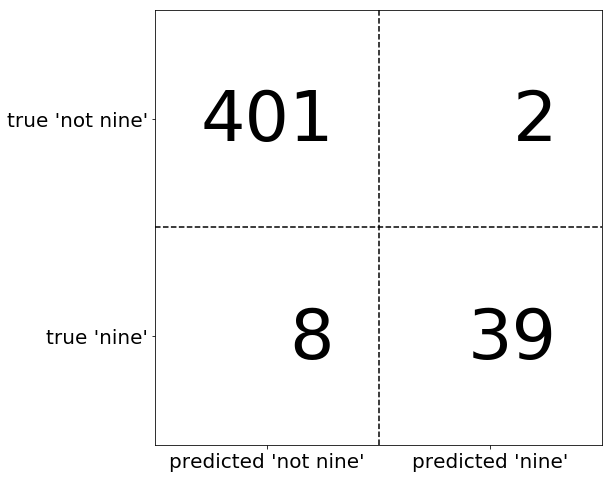

In [44]:
mglearn.plots.plot_confusion_matrix_illustration()

With the True and False Positives and True and False Negatives abbreviations, the confusion matrix is built as follows.

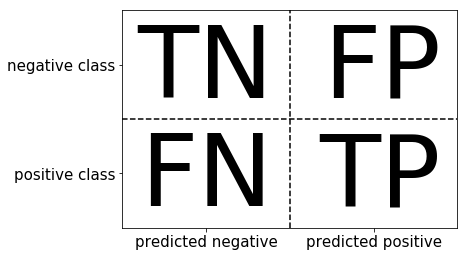

In [45]:
mglearn.plots.plot_binary_confusion_matrix()

Confusion matrix for different models.

In [46]:
print("Most frequent class:")
print(confusion_matrix(y_test, pred_most_frequent))
print("\nDummy model:")
print(confusion_matrix(y_test, pred_dummy))
print("\nDecision tree:")
print(confusion_matrix(y_test, pred_tree))
print("\nLogistic Regression")
print(confusion_matrix(y_test, pred_logreg))

Most frequent class:
[[403   0]
 [ 47   0]]

Dummy model:
[[361  42]
 [ 43   4]]

Decision tree:
[[390  13]
 [ 24  23]]

Logistic Regression
[[401   2]
 [  8  39]]


### Ways to measure the accuracy of a confusion matrix

* Relation to accuracy: Number of correct predictions divided by the number of samples
* Precison (Positive predictive value): How many positives are marked as positives, used when we want to limit the number of false positives.
* Recall: How many of the positive samples arecaptured by the positive predictions. Used when it is important to identify false negatives.

Precision and recall might be the most used in binary classification, but there are others. (Check wikipedia)

* f-score or f-measure: The harmonic mean of precision and recall:
    * F = 2 * ((precision)(recall)) / (precision + recall)
    
Let us run the f-score on the 9 vs. rest dataset from above. In this case, there is a strong distinction between the DummyClassifier and the DecisionTree, which there wasn't with the accuracy alone. The f1_score is harder to explain than accuracy though.

In [47]:
from sklearn.metrics import f1_score
print('f1 score most frequent: {:.2f}'.format(f1_score(y_test, pred_most_frequent)))
print("f1 score dummy: {:.2f}".format(f1_score(y_test, pred_dummy)))
print("f1 score tree: {:.2f}".format(f1_score(y_test, pred_tree)))
print("f1 score logistic regression: {:.2f}".format(f1_score(y_test, pred_logreg)))

f1 score most frequent: 0.00
f1 score dummy: 0.09
f1 score tree: 0.55
f1 score logistic regression: 0.89


Fortunately, scikit learn has a nice tool to calculate precison, recall adn f1_score at the same time.

The support column tells us the number of samples in a class according to the ground truth.

In [48]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred_most_frequent, target_names = ["Not nine", 'Nine']))

              precision    recall  f1-score   support

    Not nine       0.90      1.00      0.94       403
        Nine       0.00      0.00      0.00        47

   micro avg       0.90      0.90      0.90       450
   macro avg       0.45      0.50      0.47       450
weighted avg       0.80      0.90      0.85       450



In [49]:
print(classification_report(y_test, pred_dummy,
                            target_names=["not nine", "nine"]))

              precision    recall  f1-score   support

    not nine       0.89      0.90      0.89       403
        nine       0.09      0.09      0.09        47

   micro avg       0.81      0.81      0.81       450
   macro avg       0.49      0.49      0.49       450
weighted avg       0.81      0.81      0.81       450



In [50]:
print(classification_report(y_test, pred_logreg,
                            target_names=["not nine", "nine"]))

              precision    recall  f1-score   support

    not nine       0.98      1.00      0.99       403
        nine       0.95      0.83      0.89        47

   micro avg       0.98      0.98      0.98       450
   macro avg       0.97      0.91      0.94       450
weighted avg       0.98      0.98      0.98       450



The results depend very much on whether you use one class or another as the true positive. For example, in the dummy classification we get an f1 score of .9 when using the not nine as the positive class but a 0.05 when using the nine as the positive class.

However, looking at all the numbers, the Logistic Regression seems to perform quite better.

### Taking uncertainty into account

Making predictions can be seen as putting a threshold in the output of the decision functon and the predict proba function.


The decision function will take negative and positive values to predict the negative or positive class, we make the threshold 0.

Predict proba will output a probability that a sample belongs to a class. We threshold it at 0.5.

The following example has 400 samples in the negative class and 50 in the positive class. With an SVC que can get the decisions using different thersholds for the decision function.

In [51]:
X, y = make_blobs(n_samples=(400, 50), cluster_std=[7.0, 2],
                  random_state=22)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
svc = SVC(gamma=.05).fit(X_train, y_train)

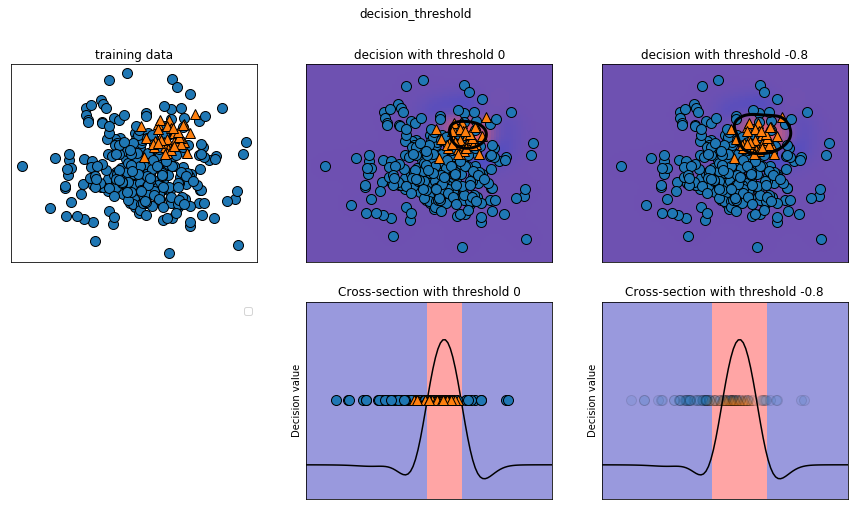

In [52]:
mglearn.plots.plot_decision_threshold()

In [53]:
print(classification_report(y_test, svc.predict(X_test)))

              precision    recall  f1-score   support

           0       0.97      0.89      0.93       104
           1       0.35      0.67      0.46         9

   micro avg       0.88      0.88      0.88       113
   macro avg       0.66      0.78      0.70       113
weighted avg       0.92      0.88      0.89       113



We can get different results by changing the value of the threshold.

In [54]:
y_pred_lower_threshold = svc.decision_function(X_test) > -.8

In [55]:
print(classification_report(y_test, y_pred_lower_threshold))

              precision    recall  f1-score   support

           0       1.00      0.82      0.90       104
           1       0.32      1.00      0.49         9

   micro avg       0.83      0.83      0.83       113
   macro avg       0.66      0.91      0.69       113
weighted avg       0.95      0.83      0.87       113



If we value precision over recall or viceversa, the easiest way to obtain better results is to change the threshold for the classification. As the numbers used in precision function can be arbitrary, it is hard to establish the threshold.

#### Note:
Do not do the last thing with the test-set try using a validation set or cross-validation.

Moving the thershold of predict_proba is actually easier, as its output is fixed from 0 to 1. The closer to 1 that the the output of predict_proba is, the more sure the algorithm is to classify a sample as the positive class.

### Precision recall curves and ROC curves

Setting a requirement on a classifier like 90% recall is called setting the operating point. This can help to make performance guarantees to customers or other stakeholders.

To look at all possible thersholds for predict_proba and the decision_function at once one can use the precission_recall_curve.
It needs the ground truth labeling and the predicted uncertainties of either the decision_function or the predict_proba.

The precision_recall_curve returns a list of precision and recall values for all possible thresholds (all values that appear in the decision function)

In [56]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, svc.decision_function(X_test))

Each point in the following graph corresponds to a possible threshold of the decision_function. We can see in ther that we can achieve a recall of 0.4 with a precision of about 0.75. 

The closer the curve is to the top right corner, the better the predictor is.

The better the model keeps a high recall as the precision goes up as well, the better. At the top, we can see that we can keep increasing the precision without affecting that much the recall, but afterwards, increasing the precision affects a lot the recall.

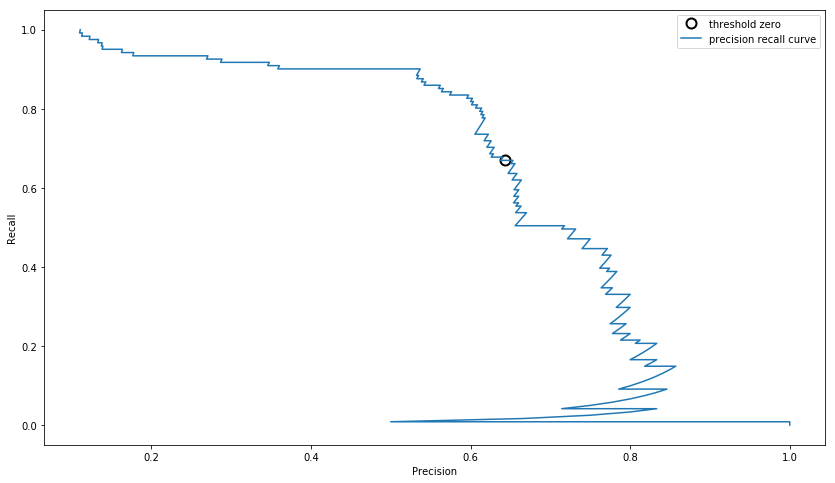

In [57]:
# Use more data points for a smoother curve
X, y = make_blobs(n_samples=(4000, 500), cluster_std=[7.0, 2], random_state=22)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
svc = SVC(gamma=.05).fit(X_train, y_train)
precision, recall, thresholds = precision_recall_curve(
    y_test, svc.decision_function(X_test))
# find threshold closest to zero
close_zero = np.argmin(np.abs(thresholds))
plt.figure(figsize = (14,8))
plt.plot(precision[close_zero], recall[close_zero], 'o', markersize=10,
         label="threshold zero", fillstyle="none", c='k', mew=2)

plt.plot(precision, recall, label="precision recall curve")
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.legend(loc="best")
plt.show()

Different models will perform different with different thresholds. Let's try with RandomForests, which uses predict_proba as it doesn't have the decision_function.

The precision_recall_curve expects as its second argument a certaintyu measure for the positve class (class 1). The default threshold for pedict_proba is 0.5, so it is the one marked on the curve for the RandomForest.

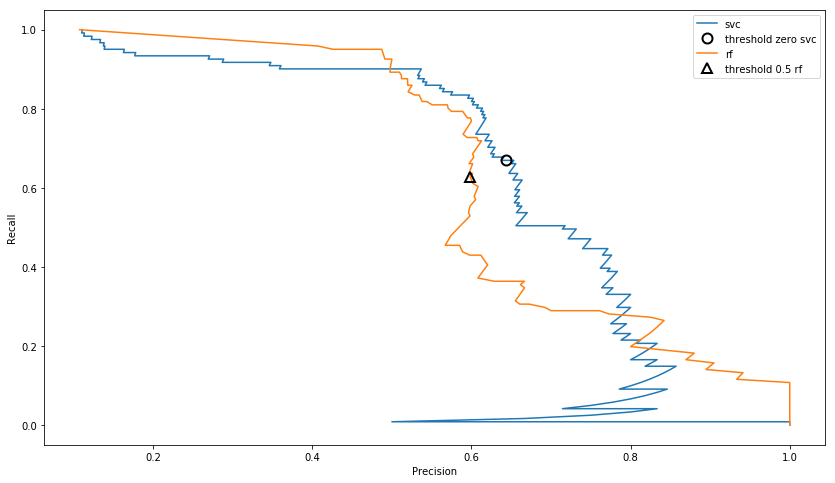

In [58]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=0, max_features=2)
rf.fit(X_train, y_train)

# RandomForestClassifier has predict_proba, but not decision_function
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(
    y_test, rf.predict_proba(X_test)[:, 1])
plt.figure(figsize = (14,8))
plt.plot(precision, recall, label="svc")

plt.plot(precision[close_zero], recall[close_zero], 'o', markersize=10,
         label="threshold zero svc", fillstyle="none", c='k', mew=2)

plt.plot(precision_rf, recall_rf, label="rf")

close_default_rf = np.argmin(np.abs(thresholds_rf - 0.5))
plt.plot(precision_rf[close_default_rf], recall_rf[close_default_rf], '^', c='k',
         markersize=10, label="threshold 0.5 rf", fillstyle="none", mew=2)
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.legend(loc="best")

plt.show()

Looking at these graphs is important because by using only the f1_score we can miss all this, as it only tells us the performance at the default thresholds.

By looking at the graphs we can see that the RF performs better at the extremes, while the SVC performs better at the center.

In [59]:
print("f1_score of random forest: {:.3f}".format(
    f1_score(y_test, rf.predict(X_test))))
print("f1_score of svc: {:.3f}".format(f1_score(y_test, svc.predict(X_test))))

f1_score of random forest: 0.610
f1_score of svc: 0.656


To compare in a more automatic way the two models, the area under the precision_recall_curve can be calculated with the average_precision_curve in scikit learn. 

We need to pass to average_precision_curve the output of either predict_proba or the decision_function, in order to consider multiple thersholds.

In [60]:
from sklearn.metrics import average_precision_score

ap_rf = average_precision_score(y_test, rf.predict_proba(X_test)[:,1])
ap_svc = average_precision_score(y_test, svc.decision_function(X_test))
print('Average precision score of Random Forest: {:.3f}'.format(ap_rf))
print('Average precision score of SVC: {:.3f}'.format(ap_svc))

Average precision score of Random Forest: 0.660
Average precision score of SVC: 0.666


### Receiver Operating Characteristics (ROC) and AUC

The ROC shows all the possible thresholds for a classifier, but it compares de False Positive Rate (FPR) against the True Positive Rate (TPR).

FPR = FP/(FP + TN)

TPR (or Recal) = TP / (TP + FN)



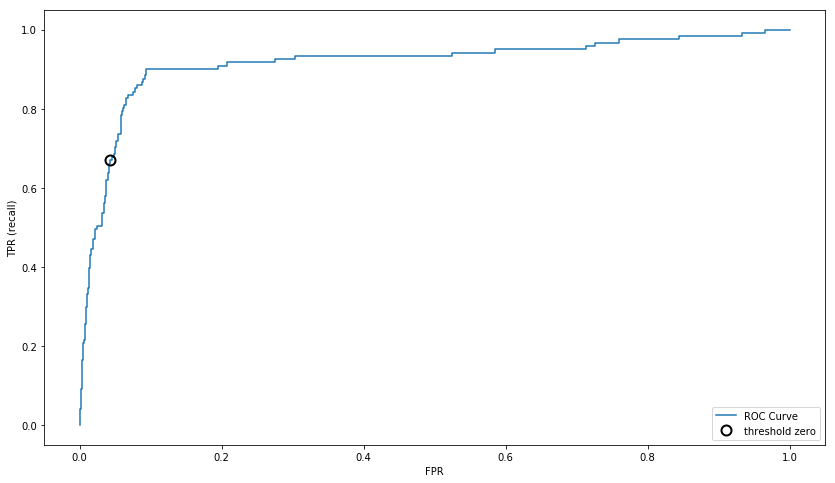

In [62]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, svc.decision_function(X_test))

plt.figure(figsize = (14,8))
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
# find threshold closest to zero
close_zero = np.argmin(np.abs(thresholds))
plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10,
         label="threshold zero", fillstyle="none", c='k', mew=2)
plt.legend(loc=4)
plt.show()

The idealfor the ROC curve is in the upper-left, as we want a high recall while keeping a low fals epositive rate.

We can get a better recall, about 0.9, without increasing so much the FPR by using a different threshold. Again, choose the threshold with a validation set, not with the test set.

Comparison of SVC against Random Forest:

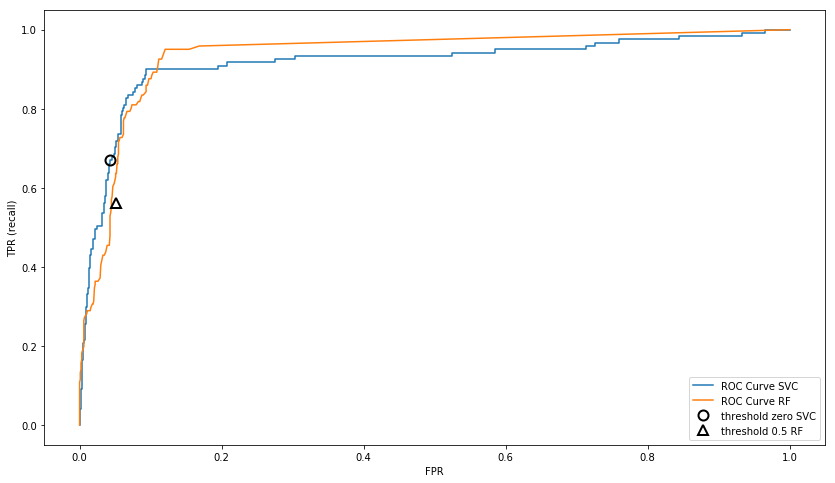

In [63]:
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])

plt.figure(figsize = (14,8))
plt.plot(fpr, tpr, label="ROC Curve SVC")
plt.plot(fpr_rf, tpr_rf, label="ROC Curve RF")

plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10,
         label="threshold zero SVC", fillstyle="none", c='k', mew=2)
close_default_rf = np.argmin(np.abs(thresholds_rf - 0.5))
plt.plot(fpr_rf[close_default_rf], tpr[close_default_rf], '^', markersize=10,
         label="threshold 0.5 RF", fillstyle="none", c='k', mew=2)

plt.legend(loc=4)
plt.show()

We can also compare ROC curves with the area under the curve by using the roc_auc_score function

In [64]:
from sklearn.metrics import roc_auc_score
rf_auc = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])
svc_auc = roc_auc_score(y_test, svc.decision_function(X_test))
print("AUC for Random Forest: {:.3f}".format(rf_auc))
print("AUC for SVC: {:.3f}".format(svc_auc))

AUC for Random Forest: 0.937
AUC for SVC: 0.916


While working with imbalanced models, the Area Under the Curve (AUC) is often a much better performance indicator than the accuracy.

The AUC results is the probability that a randomly picked point of the positive class will have a higher score according to the classifier than a randomly picked point from the negative class.

Now we can calculate the ROC for differnt values of gamma with the 9 and not nine dataset

gamma = 1.00  accuracy = 0.90  AUC = 0.50
gamma = 0.05  accuracy = 0.90  AUC = 1.00
gamma = 0.01  accuracy = 0.90  AUC = 1.00


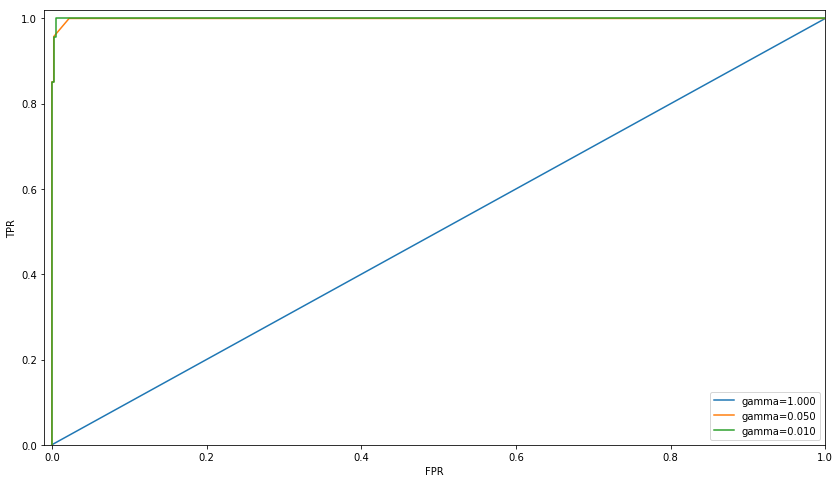

In [66]:
y = digits.target == 9

X_train, X_test, y_train, y_test = train_test_split(
    digits.data, y, random_state=0)

plt.figure(figsize = (14,8))

for gamma in [1, 0.05, 0.01]:
    svc = SVC(gamma=gamma).fit(X_train, y_train)
    accuracy = svc.score(X_test, y_test)
    auc = roc_auc_score(y_test, svc.decision_function(X_test))
    fpr, tpr, _ = roc_curve(y_test , svc.decision_function(X_test))
    print("gamma = {:.2f}  accuracy = {:.2f}  AUC = {:.2f}".format(
          gamma, accuracy, auc))
    plt.plot(fpr, tpr, label="gamma={:.3f}".format(gamma))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.xlim(-0.01, 1)
plt.ylim(0, 1.02)
plt.legend(loc="best")
plt.show()

The accuracy is the same for the three values of gamma, but we can see that the AUC is actually different for the three of them. 
With gamma = 1 we can see that the AUC is 0.5, that is basically the same as chossing randomly.

With gamma = 0.01, with AUC = 1 we can conclude that all positive points are ranked higher than all negative points according to the decision_function.

Now we can tune the model to the threshold corresponding to the upper left corner, using only the accuracy this would have never been possible.

## Metrics for Multiclass Classification

All metrics for multiclass classification are derived from the binary classification ones. Again, the accuracy is defined as the fraction of correctly classified samples and when the dataset is imbalanced, accuracy is not that great of a metric.

Let's calculate the confusion matrix for classifying the digits in the digits dataset.

In [67]:
from sklearn.metrics import accuracy_score
X_train, X_test, y_train, y_test = train_test_split(
    digits.data, digits.target, random_state=0)
lr = LogisticRegression().fit(X_train, y_train)
pred = lr.predict(X_test)
print("Accuracy: {:.3f}".format(accuracy_score(y_test, pred)))
print("Confusion matrix:\n{}".format(confusion_matrix(y_test, pred)))

Accuracy: 0.953
Confusion matrix:
[[37  0  0  0  0  0  0  0  0  0]
 [ 0 39  0  0  0  0  2  0  2  0]
 [ 0  0 41  3  0  0  0  0  0  0]
 [ 0  0  1 43  0  0  0  0  0  1]
 [ 0  0  0  0 38  0  0  0  0  0]
 [ 0  1  0  0  0 47  0  0  0  0]
 [ 0  0  0  0  0  0 52  0  0  0]
 [ 0  1  0  1  1  0  0 45  0  0]
 [ 0  3  1  0  0  0  0  0 43  1]
 [ 0  0  0  1  0  1  0  0  1 44]]


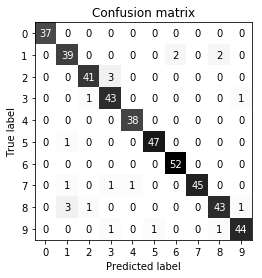

In [68]:
scores_image = mglearn.tools.heatmap(
    confusion_matrix(y_test, pred), xlabel='Predicted label',
    ylabel='True label', xticklabels=digits.target_names,
    yticklabels=digits.target_names, cmap=plt.cm.gray_r, fmt="%d")
plt.title("Confusion matrix")
plt.gca().invert_yaxis()

For the first class, the 0, there are 37 samples and all are correctly classified as all other spaces in the first row are 0. We can also see that no other class was mistakenly classified as 0, because all other entries in the first column are 0 (No false positives for class 0).
In the third row though, 3 number two were classified as the digit 3 (fourth column), there is also one digit three classified as two and one digit 8 classified as 2.

With the classification report, we can compute the precision, recall and f1 score for each class

In [69]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        37
           1       0.89      0.91      0.90        43
           2       0.95      0.93      0.94        44
           3       0.90      0.96      0.92        45
           4       0.97      1.00      0.99        38
           5       0.98      0.98      0.98        48
           6       0.96      1.00      0.98        52
           7       1.00      0.94      0.97        48
           8       0.93      0.90      0.91        48
           9       0.96      0.94      0.95        47

   micro avg       0.95      0.95      0.95       450
   macro avg       0.95      0.95      0.95       450
weighted avg       0.95      0.95      0.95       450



The most common metric for imbalanced datasets in the multiclass setting is the multiclass version of the f-score. The idea is to compute one binary f-score for eac class, with that class being the positive and all the others making up the negative class. Then, these per-class f-scores are averaged using one of the following methods:

* macro: computes the unweighted per-class f-scores, this gives equal weight to all classes no matter their size
* weighted: the mean of the per-class f-scores, weighted by their support (number of elements in each class). This is what is reported in the classification_report
* micro: computes the total number of false positives, false negatives, and true positives over all classes, and then computes precision, recall and f-score using these counts.

If we care about each same equally much, it is recommended to use the "micro" f1-score, if the care about each class equally much, it is recommended to use the "macro" one.

In [70]:
print("Micro average f1 score: {:.3f}".format(
    f1_score(y_test, pred, average="micro")))
print("Macro average f1 score: {:.3f}".format(
    f1_score(y_test, pred, average="macro")))

Micro average f1 score: 0.953
Macro average f1 score: 0.954


## Regression Metrics

Often using the R-squared in the score method is enough for evaluating regression models. Sometimes business decisions can be made on basis of the mean square error or mean absolute error, so models can be tuned through these metrics too.

## Using Evaluation Metrics in Model Selection

We can change the metric in both GridSearchCV and cross_val_score with the scoring argument in both of them if we want to use another metric for the model rather than accuracy.

In [72]:
print("Default scoring: ", cross_val_score(SVC(), digits["data"], digits["target"] == 9, cv = 5))

# providing scoring="accuracy" doesn't change the results
explicit_accuracy =  cross_val_score(SVC(), digits.data, digits.target == 9,
                                     scoring="accuracy", cv=5)
print("Explicit accuracy scoring: {}".format(explicit_accuracy))

# Using roc_auc in the socring actually changes the results
roc_auc =  cross_val_score(SVC(), digits.data, digits.target == 9,
                           scoring="roc_auc", cv=5)
print("AUC scoring: {}".format(roc_auc))

Default scoring:  [0.9        0.9        0.89972145 0.89972145 0.89972145]
Explicit accuracy scoring: [0.9        0.9        0.89972145 0.89972145 0.89972145]
AUC scoring: [0.99674211 0.99725652 0.99552804 0.99836601 0.99165807]


Using cross_validate we can compute several metrics at once:

In [73]:
res = cross_validate(SVC(), digits.data, digits.target == 9,
                     scoring=["accuracy", "roc_auc", "recall_macro"],
                     return_train_score=True, cv=5)
display(pd.DataFrame(res))

,fit_time,score_time,test_accuracy,train_accuracy,test_roc_auc,train_roc_auc,test_recall_macro,train_recall_macro
0,0.188156,0.109361,0.900000,1.0,0.996742,1.0,0.5,1.0
1,0.156210,0.121241,0.900000,1.0,0.997257,1.0,0.5,1.0
2,0.171832,0.122134,0.899721,1.0,0.995528,1.0,0.5,1.0
3,0.173514,0.093730,0.899721,1.0,0.998366,1.0,0.5,1.0
4,0.203079,0.124971,0.899721,1.0,0.991658,1.0,0.5,1.0


We can also change the metric in GridSearchCV
##### USE DEFAULT SCORING IN GREADSEARCH

In [74]:
X_train, X_test, y_train, y_test = train_test_split(
    digits.data, digits.target == 9, random_state=0)

# we provide a somewhat bad grid to illustrate the point:
param_grid = {'gamma': [0.0001, 0.01, 0.1, 1, 10]}

# using the default scoring of accuracy:
grid = GridSearchCV(SVC(), param_grid=param_grid)
grid.fit(X_train, y_train)
print("Grid-Search with accuracy")
print("Best parameters:", grid.best_params_)
print("Best cross-validation score (accuracy)): {:.3f}".format(grid.best_score_))
print("Test set AUC: {:.3f}".format(
    roc_auc_score(y_test, grid.decision_function(X_test))))
print("Test set accuracy: {:.3f}".format(grid.score(X_test, y_test)))

Grid-Search with accuracy
Best parameters: {'gamma': 0.0001}
Best cross-validation score (accuracy)): 0.970
Test set AUC: 0.992
Test set accuracy: 0.973


##### USE AUC SCORING INSTEAD

In [75]:
# using AUC scoring instead:
grid = GridSearchCV(SVC(), param_grid=param_grid, scoring="roc_auc")
grid.fit(X_train, y_train)
print("\nGrid-Search with AUC")
print("Best parameters:", grid.best_params_)
print("Best cross-validation score (AUC): {:.3f}".format(grid.best_score_))
print("Test set AUC: {:.3f}".format(
    roc_auc_score(y_test, grid.decision_function(X_test))))
print("Test set accuracy: {:.3f}".format(grid.score(X_test, y_test)))


Grid-Search with AUC
Best parameters: {'gamma': 0.01}
Best cross-validation score (AUC): 0.997
Test set AUC: 1.000
Test set accuracy: 1.000


##### USING AVERAGE PRECISION

In [77]:
# using AUC scoring instead:
grid = GridSearchCV(SVC(), param_grid=param_grid, scoring="average_precision")
grid.fit(X_train, y_train)
print("\nGrid-Search with average precision")
print("Best parameters:", grid.best_params_)
print("Best cross-validation score (AUC): {:.3f}".format(grid.best_score_))
print("Test set AUC: {:.3f}".format(
    roc_auc_score(y_test, grid.decision_function(X_test))))
print("Test set accuracy: {:.3f}".format(grid.score(X_test, y_test)))


Grid-Search with average precision
Best parameters: {'gamma': 0.01}
Best cross-validation score (AUC): 0.985
Test set AUC: 1.000
Test set accuracy: 0.996


With different metrics, different paremeters might be selected. In accuracy case gamma = 0.0001 was selected, in auc and average precision cases gamma = 0.01 were selected.

#### Most relevant parameters for scoring parameter for classification
* accuracy (the default)
* roc_auc: area under the ROC curve
* average_precision for the area unde the precision-recall curve
* f1
* f1_macro
* f1_weighted

#### Most relevant parameters for scoring parameter for regression
* r2
* mean_squared_error
* mean_absolute_error

A full list of supported arguments is in the sci-kit learn documentation

In [79]:
from sklearn.metrics.scorer import SCORERS
print("Available scorers:")
print(sorted(SCORERS.keys()))

Available scorers:
['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision', 'balanced_accuracy', 'brier_score_loss', 'completeness_score', 'explained_variance', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'fowlkes_mallows_score', 'homogeneity_score', 'mutual_info_score', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_median_absolute_error', 'normalized_mutual_info_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'roc_auc', 'v_measure_score']
